In [50]:
# !pip install scikit-learn
# !pip install scikit-image
import time
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

READ DATASET AND CROP OBJECT



In [51]:
image_folder_path=r"D:\image_clf\traffic_sign_detection\images"
ano_folder_path=r"D:\image_clf\traffic_sign_detection\annotations"

img_lst=[]
label_lst=[]

for xml_file in os.listdir(ano_folder_path):
    xml_filepath=os.path.join(ano_folder_path,xml_file)
    tree=ET.parse(xml_filepath)
    root=tree.getroot()
    folder=root.find('folder').text
    img_filename=root.find('filename').text
    img_filepath=os.path.join(image_folder_path,img_filename)
    img=cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname=obj.find('name').text
        if classname == 'trafficlight':
            continue
        xmin=int(obj.find('bndbox/xmin').text)
        ymin=int(obj.find('bndbox/ymin').text)
        xmax=int(obj.find('bndbox/xmax').text)
        ymax=int(obj.find('bndbox/ymax').text)

        obj_img=img[ymin:ymax,xmin:xmax]
        img_lst.append(obj_img)
        label_lst.append(classname)

print(len(img_lst))
print(len(label_lst))

1074
1074


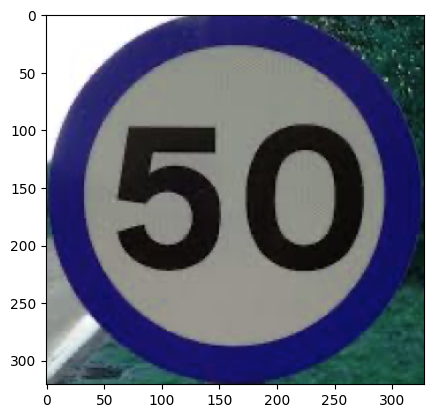

In [52]:
plt.imshow(img_lst[0])

PREPROCESSING IMAGES

In [53]:
def preprocess_img(img):
    if len(img.shape)>2:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img.astype(np.float32)
    resized_img=resize(
        img,
        output_shape=(32,32),
        anti_aliasing=True
    )
    hog_feature=feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )
    return hog_feature

In [54]:
img_features_lst=[]
for img in img_lst:
    hog_features=preprocess_img(img)
    img_features_lst.append(hog_features)
img_features=np.array(img_features_lst)


ENCODE LABEL

In [55]:
label_encoder=LabelEncoder()
encoded_label=label_encoder.fit_transform(label_lst)
print(label_encoder.classes_)
print(encoded_label)

['crosswalk' 'speedlimit' 'stop']
[1 1 1 ... 2 2 2]


CREATE TRAIN,VAL SET

In [56]:
random_state=0
test_size=0.3
is_shuffle=True

X_train,X_val,y_train,y_val=train_test_split(
    img_features,
    encoded_label,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
    )

NORMALIZATION

In [57]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)


TRAIN AND EVALUATE SVM MODEL

In [58]:
clf=SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5
)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_val)
score=accuracy_score(y_true=y_val,y_pred=y_pred)
print("Accuracy score : ",score)


Accuracy score :  0.9721362229102167


TRAFFIC SIGN LOCALIZATION

In [59]:
def sliding_window(img,window_sizes,stride,scale_factor):
    img_height,img_width=img.shape[:2]
    windows=[]
    for window_size in window_sizes:
        window_width,window_height=window_size
        for ymin in range(0,img_height-window_height+1,stride):
            for xmin in range(0,img_width-window_width+1,stride):
                xmax=xmin+window_width
                ymax=ymin+window_height
                windows.append([xmin,ymin,xmax,ymax])
    return windows

In [60]:
def pyramid(img,scale=0.8,min_size=(30,30)):
    acc_scale=1.0
    pyramid_imgs=[(img,acc_scale)]
    i=0
    while True:
        acc_scale=acc_scale*scale
        h=int(img.shape[0]*acc_scale)
        w=int(img.shape[1]*acc_scale)
        if h<min_size[0] or w<min_size[1]:
            break
        img=cv2.resize(img,(w,h))
        pyramid_imgs.append((img,acc_scale*(scale**i)))
        i+=1
    return pyramid_imgs



In [74]:
bboxs=[]
confidence_threshold=0.9
window_sizes=[(30,30),(50,50),(70,70)]
image_test=cv2.imread(r"D:\image_clf\traffic_sign_detection\images\road85.png")
pyramid_imgs=pyramid(image_test)
for pyramid_img_infor in pyramid_imgs:
    pyramid_img,scaler_factor=pyramid_img_infor
    window_lst=sliding_window(
        pyramid_img,
        window_sizes=window_sizes,
        stride=2,
        scale_factor=scaler_factor
    )
    for window in window_lst:
        xmin,ymin,xmax,ymax=window
        object_img=pyramid_img[ymin:ymax,xmin:xmax]
        preprocessed_img=preprocess_img(object_img)
        nomalized_img=scaler.transform([preprocessed_img])[0]
        decision=clf.predict_proba([nomalized_img])[0]
        if np.all(decision<confidence_threshold):
            continue
        else:
            predict_id=np.argmax(decision)
            conf_score=decision[predict_id]
            xmin=int(xmin/scaler_factor)
            ymin=int(ymin/scaler_factor)
            xmax=int(xmax/scaler_factor)
            ymax=int(ymax/scaler_factor)
            bboxs.append([xmin,ymin,xmax,ymax,predict_id,conf_score])


In [75]:
print(len(bboxs))

62


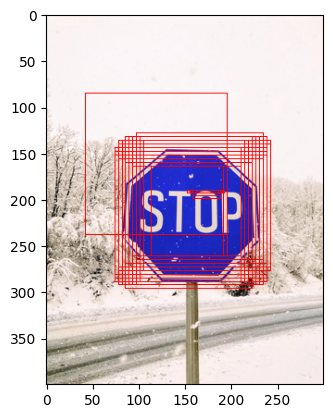

In [76]:
def plot_box(img,box):
    xmin=box[0]
    ymin=box[1]
    xmax=box[2]
    ymax=box[3]
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color=(255,0,0),thickness=1)
    return img
for box in bboxs:
    image_bboxed=plot_box(image_test,box)
plt.imshow(image_bboxed)
